本项目试图通过用户输入的**领域关键词**或者**研究者名**自动生成sematic scholar的学者网络(citation graphs)，并由此排出相关的综述文献

1. 链接semantic scholar的API
2. 找到合适的存储结构存取扒取的链接关系（结点是研究者，有向/双向网络）
3. 判断已有网络是否合适（如是否偏离最初搜索的关键词等，网络拓扑是否接近小世界网络等）
4. 可视化存储的网络
5. 根据研究者的paper提取他的研究关键词
6. 划分网络的亚结构构成圈子

~~Bugs~~ Features:
- 不挂vpn会timeout,并且经常由于网络原因中断
- 同一个人根据研究领域以及名字缩写会有复数个页面
- 最后生成的图会有重叠，多试几次
- 最后生成map的大小受到网络因素制约

In [1]:
#导入所需包
import requests
from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import textrazor

textrazor.api_key = "66d4228efb9e48e83189897b75e3b394ea491172f45ccca624508d26"

Step 1
- 使用Request链接API成功，如http://s2-public-api-prod.us-west-2.elasticbeanstalk.com/ 实例所示，但是API没有提供我们最关心的influence，并且根据引文自己生成很麻烦，所以考虑使用爬虫(web抓取)获取influence部分
- 根据https://www.semanticscholar.org/robots.txt 中的内容，我们可以爬取Author页面。但是禁止爬取search部分，因此根据领域关键词来生成的打算可以吹了
- WTF, influence部分采用的是动态网页，不能用request.get，并且逆向此过程试图找出JS脚本失败了
- 开始采用Selenium+Chrome(headless)来爬取动态网页
- WTF, 采用的是响应式布局，Elements的位置会动,使用headless的话可视界面调试得到的xpath路径不能用
- 差点被这傻逼前端气死，好在我技高一筹
- WTF,使用headless会导致窗口过小悬停不到相关人名上对应的url出不来
- 最终成功提取了相关的influence关系，剩下的根据id从api获取即可
    

In [2]:
class Author(object):
    #定义作者类，其中包含他的基本属性id，名字，影响，是在后续网络中的节点
    
    def __init__(self, ids):
        self.id=ids
        self.influence=[]
        self.influenceby=[]
        #通过id链接api,并用request自带的json解码将api得到的json格式转为python字典
        self.data=requests.get('http://s2-public-api-prod.us-west-2.elasticbeanstalk.com/v1/author/'+str(self.id)).json()
        self.name=self.data['name']
        
    
    def get_influence(self):

        # 创建可见的Chrome浏览器， 方便调试
        #driver = webdriver.Chrome('C:\Program Files (x86)\Google\Chrome\Application\chromedriver')
        #driver.set_window_size(800, 600)
        
        # 创建Chrome的无头浏览器，默认窗口大小是800x600
        opt = webdriver.ChromeOptions()
        opt.headless = True
        driver = webdriver.Chrome('C:\Program Files (x86)\Google\Chrome\Application\chromedriver',options=opt)
        
        #最大化窗口（仅可见）
        #driver.maximize_window()
        #设置隐形等待防止网速过慢报错
        driver.implicitly_wait(20)
        
        # get方式打开网页
        driver.get("https://www.semanticscholar.org/author/"+str(self.id))
        #print('-open page complet-')
        
        #点击influence选项卡
        sleep(15)
        driver.find_element_by_xpath('//*[@id="app"]/div/div[2]/div/div/div/div/div/section/div/main/div[1]/ul/li[2]/span').click()
        
        #首先定位到influence_graph
        influence_graph=driver.find_element_by_xpath('//*[@id="app"]/div/div[2]/div/div/div/div/div/section/div/main/div[2]')
        
        #调试看influence_graph下有什么节点
        #a=influence_graph.find_elements_by_xpath('.//*')
        #for s in a:
        #    print(s.get_attribute("class"))
        
        #为了解决响应式布局在其下搜索节点文本
        #找到在小窗口中包含人名的10个节点
        people=influence_graph.find_elements_by_xpath('.//*[@class="influence-graph__node__text"]')
        #print('-Reading page complet-')
        
        t=1
        for person in people:
            #print(person.text)
            if t==6:
                #滚动窗口
                driver.execute_script("window.scrollBy(0,1000)")
            #鼠标悬停在其上显示链接
            ActionChains(driver).move_to_element(person).perform()
            #获取包含链接的节点
            Link=person.find_element_by_xpath('./..//*[@class="influence-graph__menu__item authorProfileLink"]/a')
            #print(Link.get_attribute("href"))
            #print('-----------------')
            url=Link.get_attribute("href")
            id=url.rsplit("/",1)[1]
            if t<6:
                self.influenceby.append(id)
            else:
                self.influence.append(id)
            t=t+1
        driver.quit()

Step 2

- 首先要确定我们要如何通过influence爬取网络，根据前两次人工绘制的情况来看，我在人工绘制过程中是先从一篇近年新颖的文章找到一位nobody研究者（相关influence中做相关领域的以及退坑的居多），再根据他的线路一步步人工筛选走到主流网络中。这样对于自动爬取无疑是很难实现的，因此本脚本为了减少工作量建议直接使用大佬作为初始结点，但这样就会有遗漏一些新研究者的可能
- 关于最后的网络规格：根据前两次经验，~50名手动筛选的研究者就可以形成比较漂亮的图，并且考虑到边缘的节点距离中心节点普遍距离<=4，因此可以做4次迭代，最多包含1+10+100+1000+10000=11111个节点,剩下筛选工作在观察生成网络的统计情况之后再说吧
- 关于网络结构，采用networkx包
- 淦，那边服务器今天炸了 改天再说
- 一不小心没注意，初始得到的id是int类型而通过爬虫爬取的是str，导致在网络G中不判重复
- 实际情况是弱弱电脑的计算力只能做三次迭代

In [4]:
G = nx.Graph()
Authorlist=[]          #用于记录每一轮迭代产生的新节点
Authorlistnew=[]       #用于记录每一轮迭代产生的新id
idlist=[]              #用于记录已有id

#选择作为初始索引的作者 Robert E W Hancock 注意其因为名字缩写不同有三个页面，这里使用id=143696638
ini_id='143696638'
DD0 = Author(ini_id)

G.add_node(ini_id,name=DD0.name,person=DD0)
Authorlist.append(DD0)
idlist.append(ini_id)

#进行多少轮搜索
for t in range(1,4):
    print("---processing round %d" %(t))
    for person in Authorlist:
        person.get_influence()
        print("------get influence of %s done " %(person.name))
        for perid in person.influenceby:
            Authorlistnew.append(perid)
            G.add_node(perid)
            G.add_edge(perid,person.id)
            
        for perid in person.influence:
            Authorlistnew.append(perid)
            G.add_node(perid)
            G.add_edge(perid,person.id)
    
    #去除新产生id的重复项
    Authorlisttemp=list(set(Authorlistnew))
    Authorlistnew.clear()
    Authorlist.clear()
    
    for ids in Authorlisttemp:
        if ids not in idlist:
            idlist.append(ids)
            per=Author(ids)
            Authorlist.append(per)
            G.nodes[ids]['name']=per.name
            G.nodes[ids]['person']=per
    Authorlisttemp.clear()
    
del Authorlist
del Authorlistnew

print("---------------------D O N E--------------------------")

---processing round 1
------get influence of Robert E W Hancock done 
---processing round 2
------get influence of Robert E. W. Hancock done 
------get influence of Joost J Oppenheim done 
------get influence of Håvard Jenssen done 
------get influence of Neeloffer Mookherjee done 
------get influence of Robert E. W. Hancock done 
------get influence of Reza Falsafi done 
------get influence of Robert Bals done 
------get influence of Richard L Gallo done 
---processing round 3
------get influence of Nicole J Afacan done 
------get influence of Joseph S Lam done 
------get influence of Henning Hermjakob done 
------get influence of Richard D. Ye done 
------get influence of Kenshi Yamasaki done 
------get influence of Mahadevappa Hemshekhar done 
------get influence of Victor Nizet done 
------get influence of Donald J Davidson done 
------get influence of Octávio Luís Franco done 
------get influence of Sylvie Chevalier done 
------get influence of Claus F Vogelmeier done 
------get i

In [5]:
#保存
filename = 'Graph_raw'
filename2= 'idlist'

f = open(filename, 'wb')
pickle.dump(G, f)
f.close()

f = open(filename2, 'wb')
pickle.dump(idlist, f)
f.close()

In [18]:
filename = 'Graph_raw'
filename2= 'idlist'

f = open(filename, 'rb')
G = pickle.load(f)
f.close()

f = open(filename2, 'rb')
idlist = pickle.load(f)
f.close()

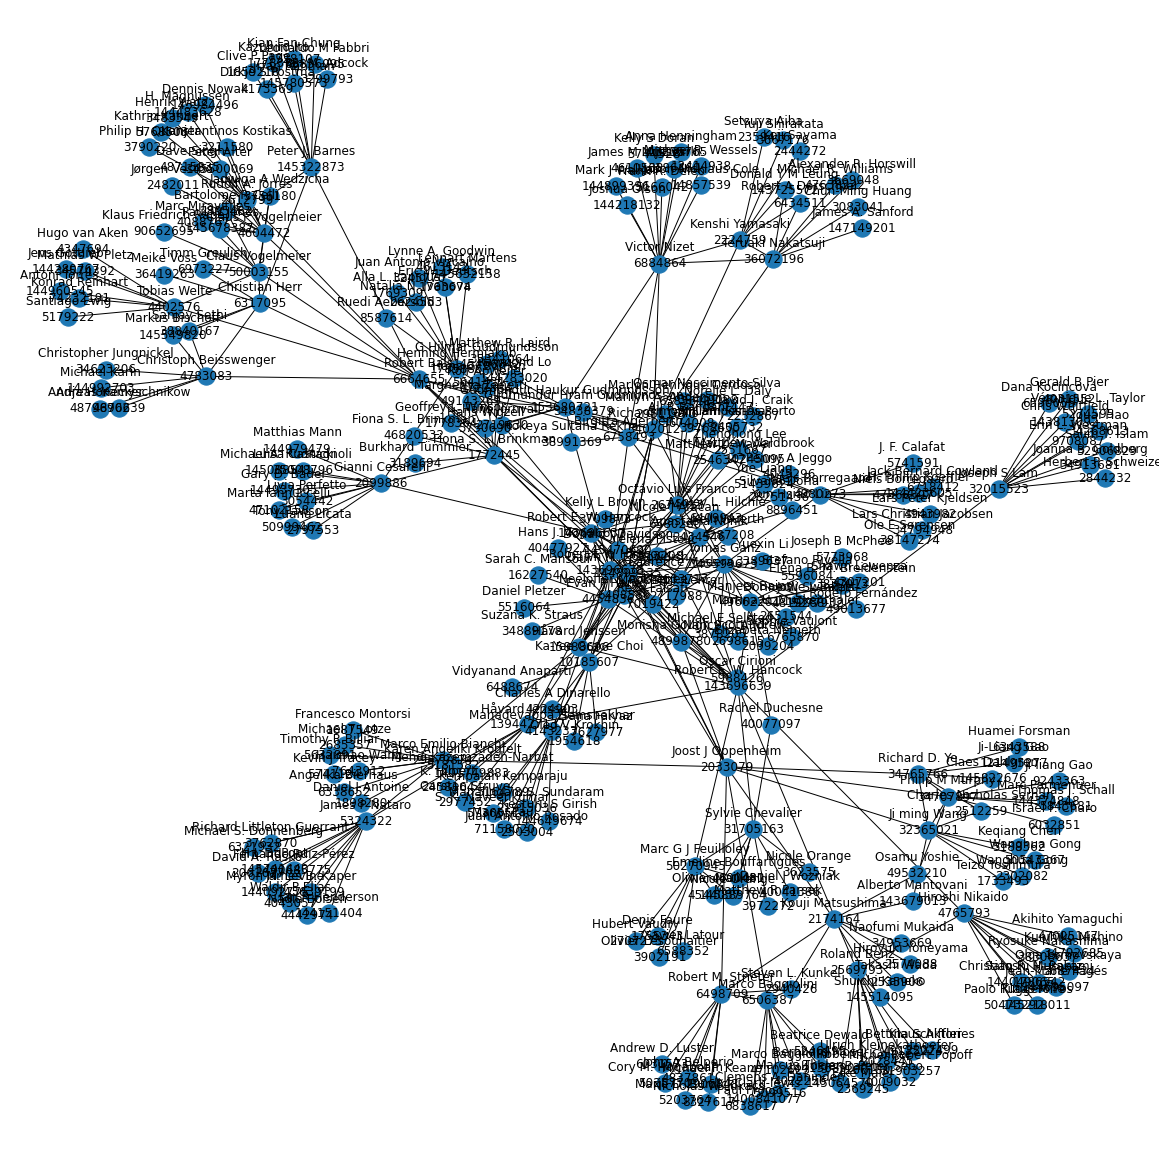

In [5]:
#使用spring layout来自动规划绘图中的节点位置
pos = nx.spring_layout(G)

plt.figure(figsize=(16,16))

nx.draw(G,pos,with_labels=True)

#绘制姓名
node_labels = nx.get_node_attributes(G, 'name')
for p in pos:  # raise text positions
    pos[p][1] += 0.03
nx.draw_networkx_labels(G, pos, labels=node_labels)

#显示RAW Network
plt.show()

step 3

- 我们需要一个筛选机制来确定这个人的influence是否与我们一开始想要搜索的领域相关以及高质量。根据前两次经验，处于中心的大佬的度可以达到>=10，并且机器爬取不做筛选应该会更高。
- 同时为了不trap在影响力小的研究者中，用于筛选有两种思路，一是先生成网络，最后根据度的排序来剔除，二是参考发表文章数、高引数等来作为依据。
- 首先绘制度分布曲线看看，实际情况中因为能被大佬link的都是大佬，所以似乎不用做个人学术量的筛选
- 去除度=1的节点，先试着对比下人工的图看看效果吧，通过对比人工图以及确认过后我们发现，关键的人物都能包含在生成的网络中，但是有一部分不相干的子网络（Robert bals衍生的子网络为例）
- 为了去除这些“中介”，一般而言计算Current Flow Betweenness (https://www.sci.unich.it/~francesc/teaching/network/flowcentrality.html) 会是一个好主意，但是这样的话中心节点的得分会很高，因此考虑结合其他中心性计算或者Plan B
- Plan B: 依次将结点拿掉，找到会将网络变为为两个不连通的图的结点

[0, 200, 21, 5, 0, 0, 0, 1, 7, 14, 12, 8, 3, 0, 3, 1, 1, 0, 0, 0, 0, 1]


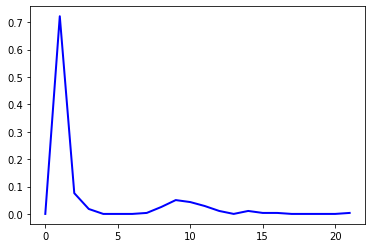

In [19]:
degree =  nx.degree_histogram(G)
print(degree)
x = range(len(degree))                             #生成x轴序列，从1到最大度
y = [z / float(sum(degree)) for z in degree] 
#将频次转换为频率，这用到Python的一个小技巧：列表内涵，Python的确很方便：）
plt.plot(x,y,color="blue",linewidth=2)           #绘制度分布曲线 
plt.show()

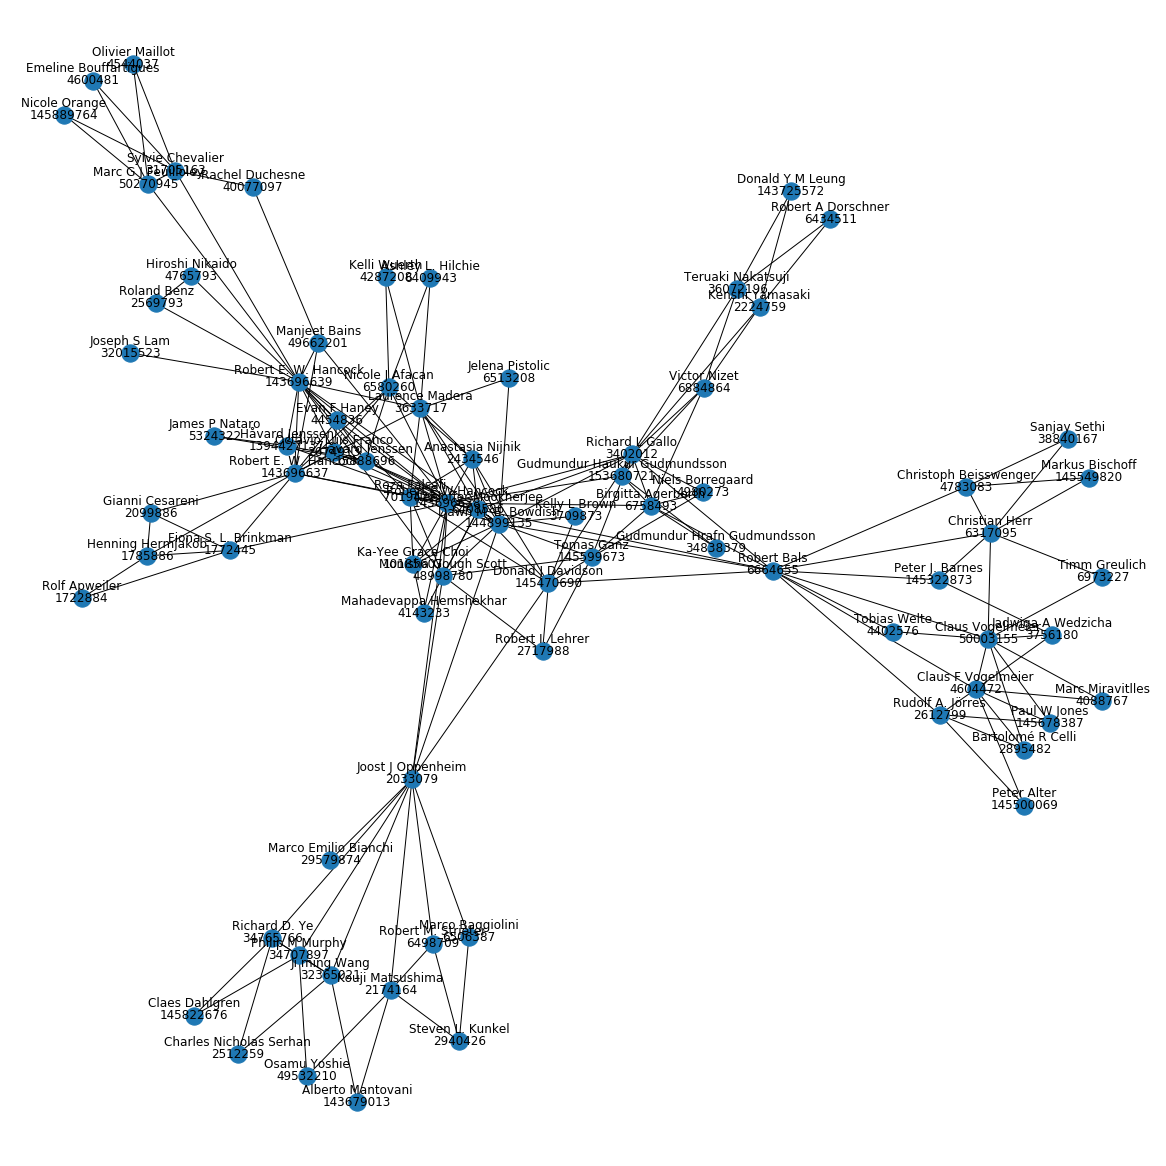

In [20]:
#备份
H=G.copy()

#去除度为1的节点
remove = [node for node,degree in H.degree() if degree == 1]
H.remove_nodes_from(remove)

pos = nx.spring_layout(H)
plt.figure(figsize=(16,16))
nx.draw(H,pos,with_labels=True)
#绘制姓名
node_labels = nx.get_node_attributes(H, 'name')
for p in pos:  # raise text positions
    pos[p][1] += 0.02
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

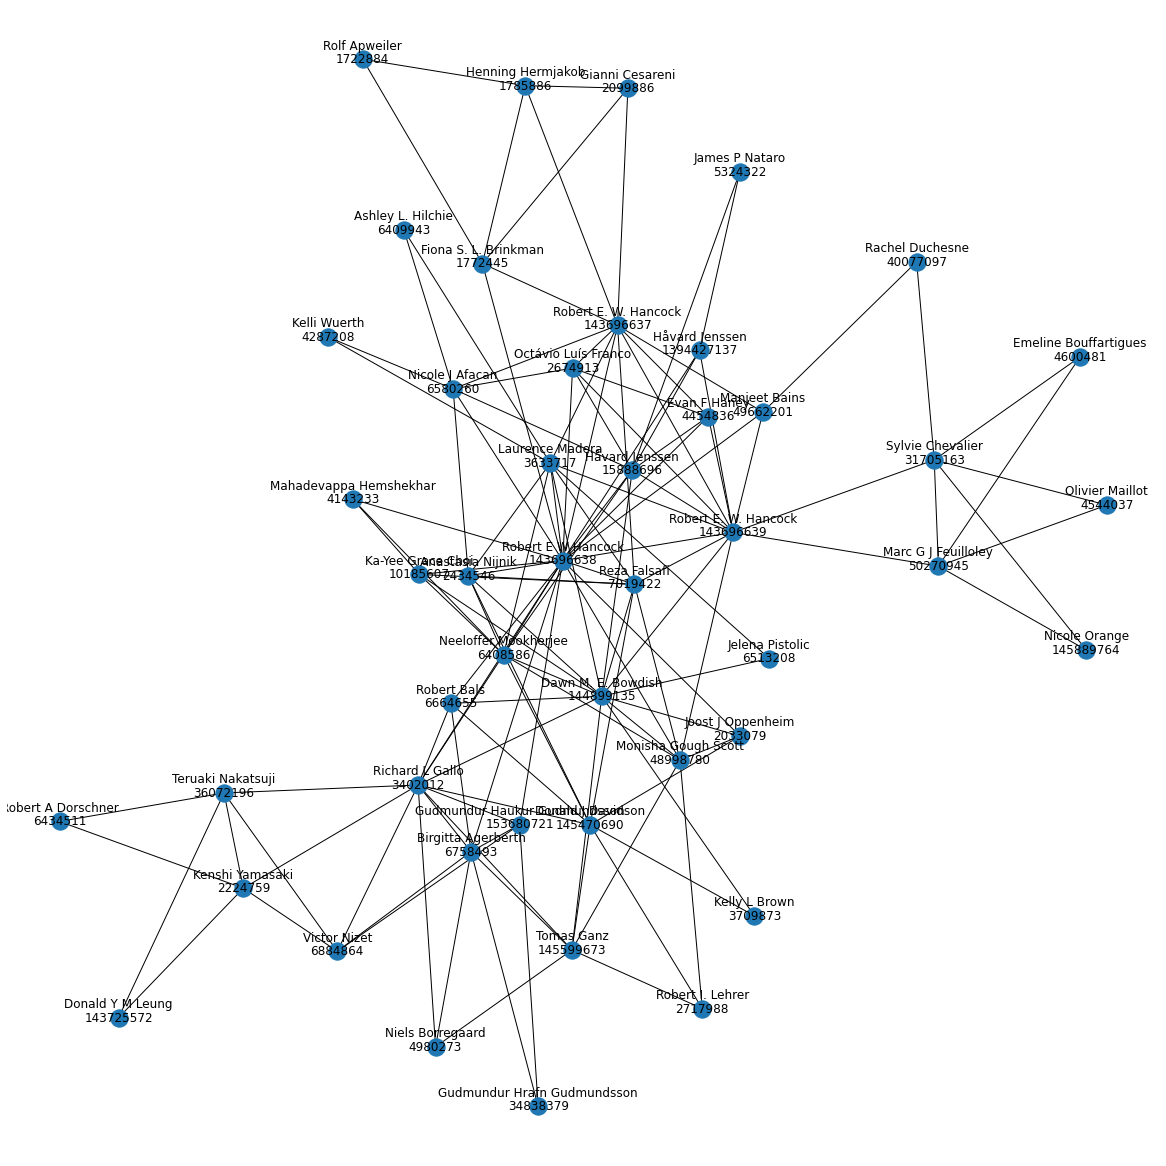

In [23]:
#找出起到中介作用的节点
remove=[]
for node in H.nodes():
    F=H.copy()
    F.remove_node(node)
    if nx.is_connected(F) == False:
        #print(node)
        #print(nx.number_connected_components(F))
        remove.append(node)

#移除中介节点取其余子图
ini_id='143696638'
F=H.copy()
F.remove_nodes_from(remove)
remove.clear()
for node in F.nodes():
    if nx.has_path(F, node, ini_id) == False:
        remove.append(node)
        
F=H.copy()
F.remove_nodes_from(remove)
pos = nx.kamada_kawai_layout(F)
plt.figure(figsize=(16,16))
nx.draw(F,pos,with_labels=True)
#绘制姓名
node_labels = nx.get_node_attributes(F, 'name')
for p in pos:  # raise text positions
    pos[p][1] += 0.02
nx.draw_networkx_labels(F, pos, labels=node_labels)
plt.show()

step 4

- 我们已经得到了可能与该领域高度相关的研究圈子了，下一步我们想要给每个人贴一些有关他们研究的关键词
- 思路有两个，一个是依据文章的标题做关键词提取，但这个转了一圈没有合适的包以及数据集，因此一转Plan B
- Plan B semantic scholar 中部分文章页面会有Topic项，由此可以得出此文相关的关键词
- 实际上操作过后发现不行，同义词太多了词频叠不上去，而且自动生成的topic更像是文中用的方法居多
- 找到了可以执行关键词提取的api (https://www.textrazor.com/),只要将文章标题整合即可生成准确率还行的Topic

In [14]:
paperlist=[]
client = textrazor.TextRazor(extractors=["topics"])
for node in F:
    #提取每个人所有文章的标题
    paperlist=[paper['title'] for paper in F.nodes[node]['person'].data['papers']]
    #调用关键词提取，并分析标题集合
    response = client.analyze(' '.join(paperlist))
    #提取生成得分=1的topic,将tag写成节点属性
    F.nodes[node]['tag']= [topic.label for topic in response.topics() if topic.score==1]
    paperlist.clear()
    print("---Extract topic for %s done " %(F.nodes[node]['person'].name))
    print(F.nodes[node]['tag'])
del paperlist
print('------------------DONE--------------------')

---Extract topic for Robert E W Hancock done 
['Antimicrobial peptides', 'Immune system', 'Pseudomonas aeruginosa', 'Innate immune system', 'Cathelicidin', 'Lipopolysaccharide', 'Antibiotic', 'Biofilm', 'Antimicrobial resistance', 'Pseudomonas', 'Bacteria', 'Drug resistance', 'Infection', 'Protein', 'Inflammation', 'Toll-like receptor', 'Cell membrane', 'Immunotherapy', 'Antimicrobial', 'Monocyte', 'Adaptive immune system', 'Neutrophil', 'Cystic fibrosis', 'Signal transduction', 'Gene expression', 'Mitochondrion', 'Macrophage', 'Cell (biology)', 'Interleukin-1 family', 'Antibody', 'T cell', 'Porin (protein)', 'Antigen', 'Gene', 'Organisms', 'Medical specialties', 'Biotechnology', 'Life sciences', 'Cell biology', 'Immunology', 'Biology', 'Biochemistry', 'Molecular biology']
---Extract topic for Robert E. W. Hancock done 
['Pseudomonas aeruginosa', 'Antimicrobial peptides', 'Pseudomonas', 'Lipopolysaccharide', 'Antibiotic', 'Cell membrane', 'Bacteria', 'Gram-negative bacteria', 'Escheric

In [68]:
for node in F:
    F.nodes[node]['id']=node
    F.nodes[node]['filed']=F.nodes[node]['tag'][0:5]

In [59]:
filename = 'Graph_process'

f = open(filename, 'wb')
pickle.dump(F, f)
f.close()

In [3]:
filename = 'Graph_process'

f = open(filename, 'rb')
F = pickle.load(f)
f.close()

step 5

- 我们已经基本得到我们关心的信息了：网络结构，每个节点的名字id以及研究大方向，下一步就是可视化，plan A是在python内直接绘图
- Plan B是将无用信息去掉然后输出为cytoscape可读取格式
- Plan B有点拉跨，图是好看不过信息不足
- 突然发现使用的是史前版本的juypterlab 扩展安不上去
- 字符有重叠，需要调整一下pos
- 因为空间有限仅显示前5个tag

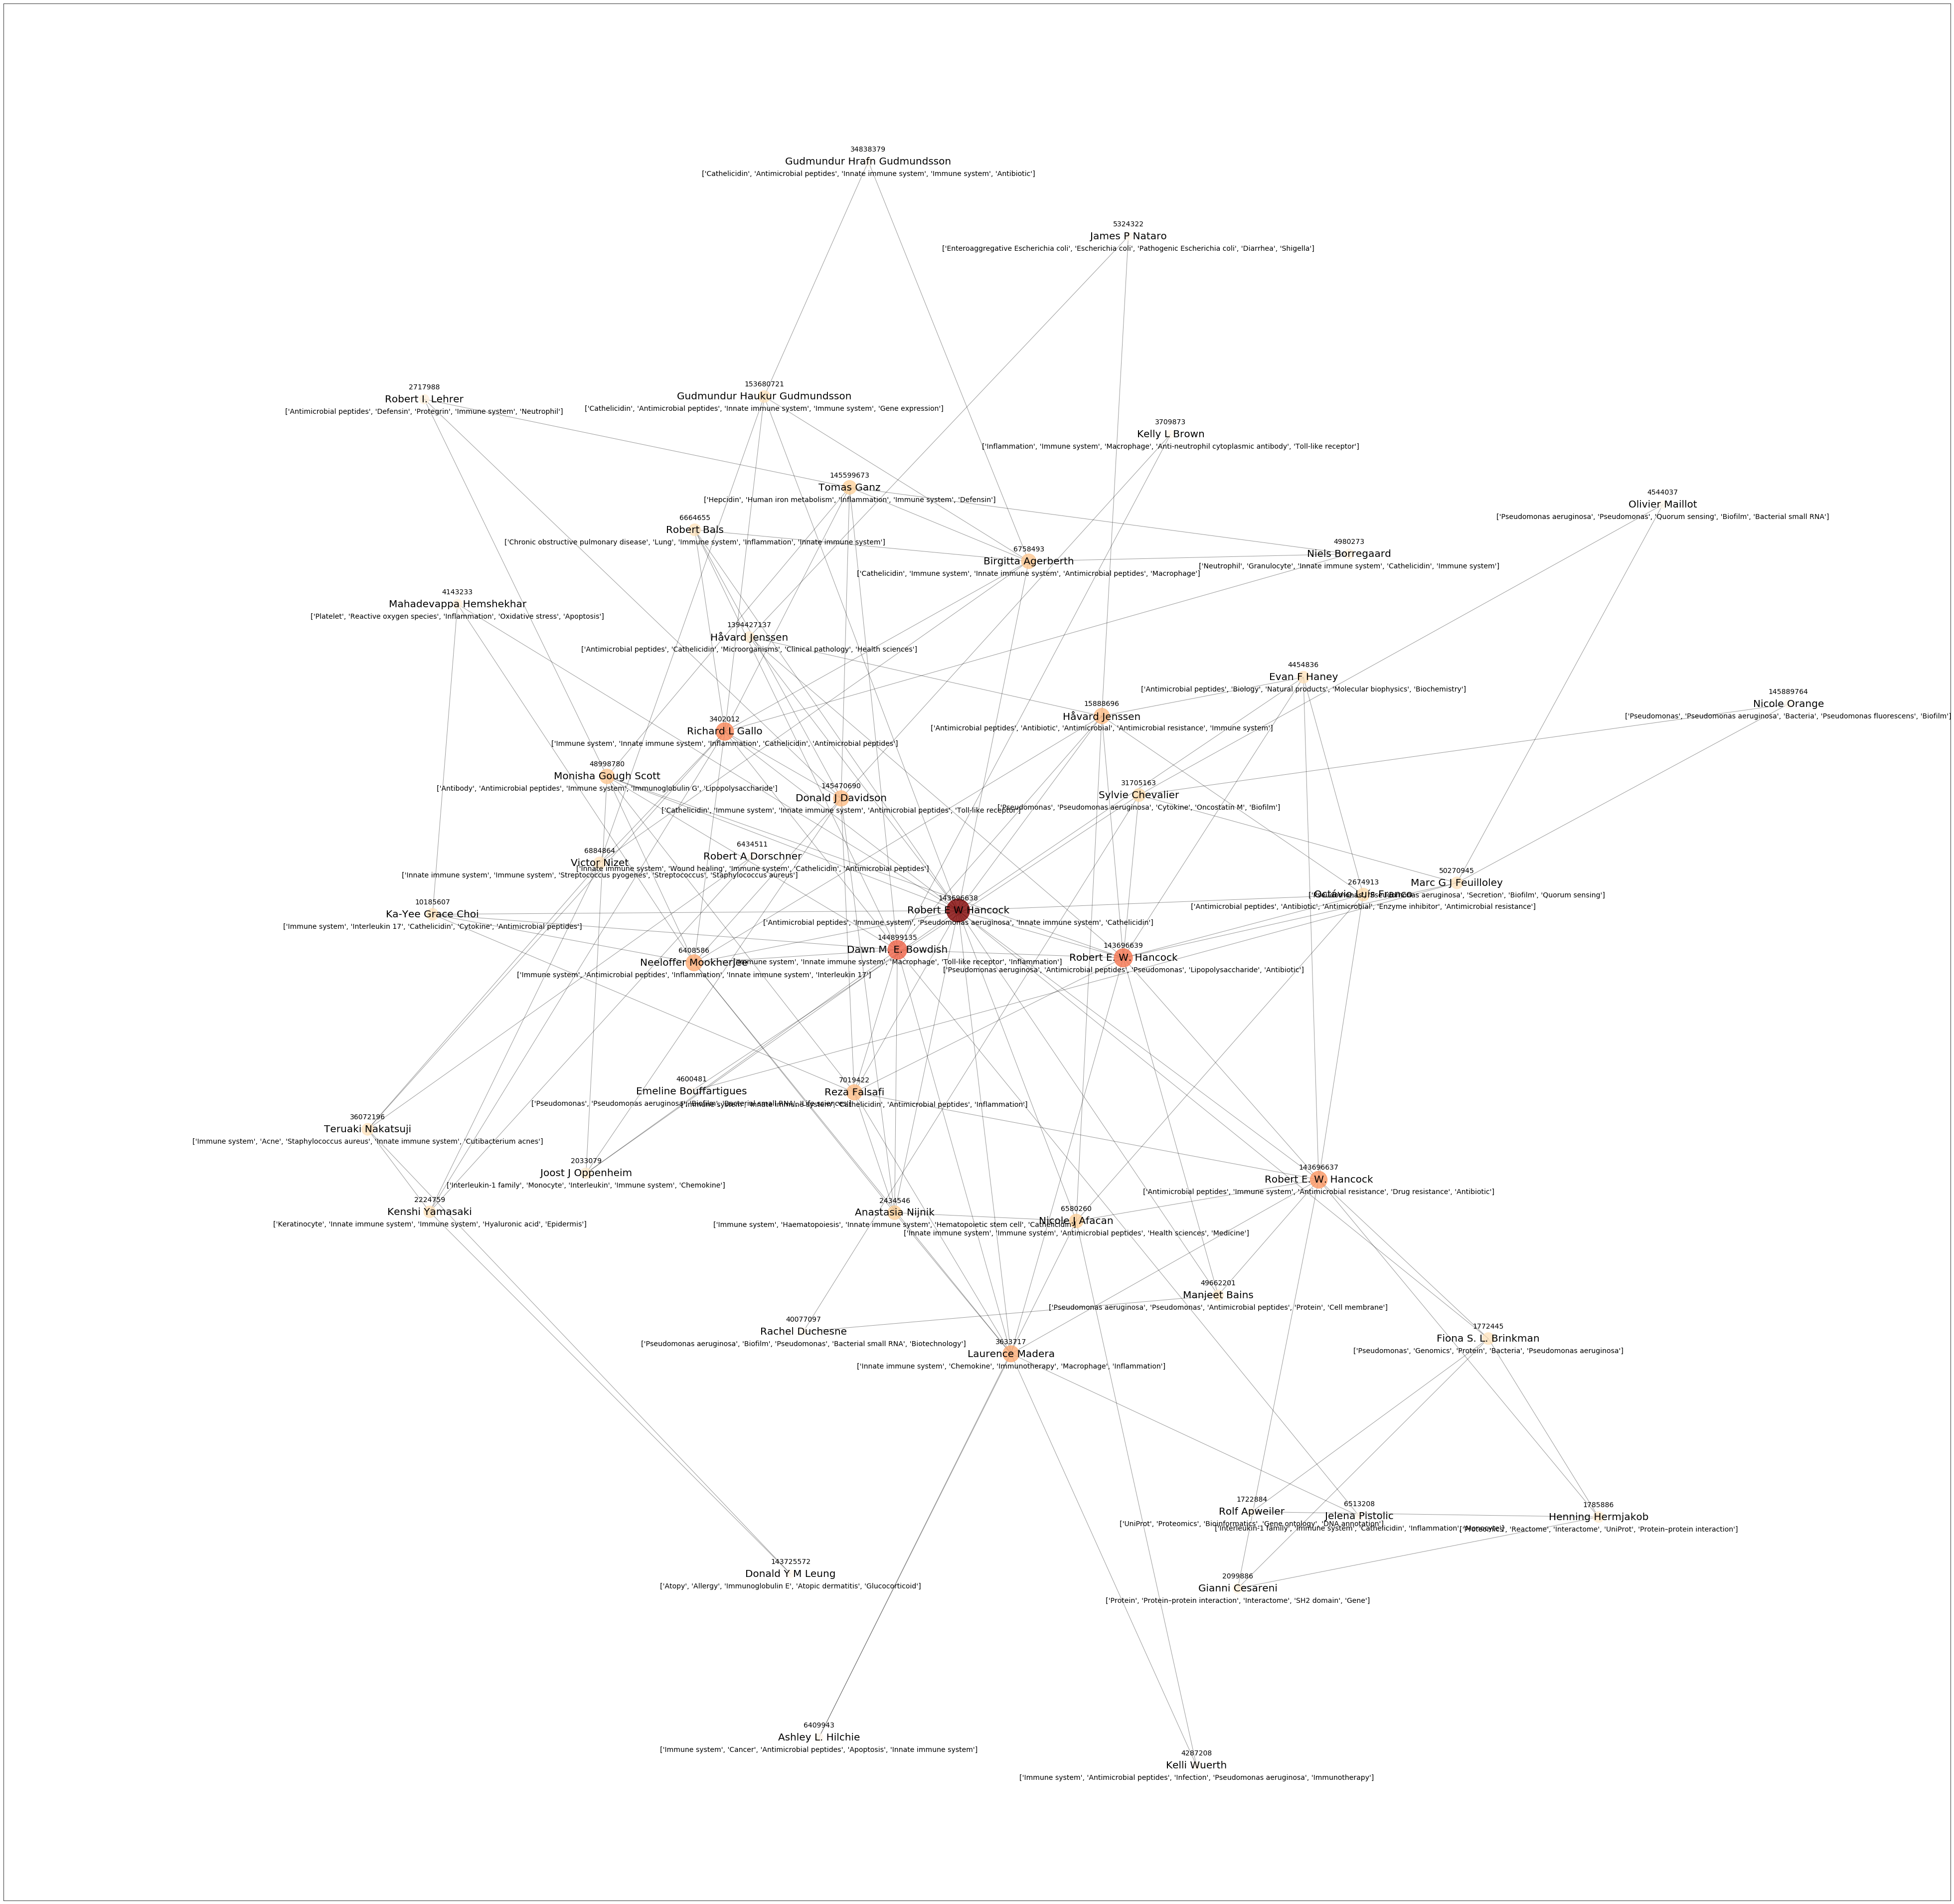

In [41]:
T=F.copy()
#根据度划分颜色和大小
sizes = [80 + T.degree(node) * 100 for node in T.nodes()]

pos = nx.spring_layout(T, k=0.8)

plt.figure(figsize=(70,70))

nx.draw_networkx_edges(T, pos, alpha=0.4)
nx.draw_networkx_nodes(
    T,
    pos,
    node_size=sizes,
    node_color=sizes,
    cmap='OrRd',
    alpha=0.8,
)

xmax = 1.2 * max(xx for xx, yy in pos.values())
ymax = 1.2 * max(yy for xx, yy in pos.values())

node_labels = nx.get_node_attributes(T, 'name')
nx.draw_networkx_labels(T, pos, labels=node_labels, font_size=20)

node_labels = nx.get_node_attributes(T, 'id')
for p in pos:  # raise text positions
    pos[p][1] += 0.015
nx.draw_networkx_labels(T, pos, labels=node_labels, font_size=14)

node_labels = nx.get_node_attributes(T, 'filed')
for p in pos:  # raise text positions
    pos[p][1] -= 0.03
nx.draw_networkx_labels(T, pos, labels=node_labels, font_size=14)

plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.savefig('scholar.png')
plt.show()

关于结果：

- 我们可以看见，处在网络最中心的Hancock虽然有着起始结点的加成，但他是当之无愧的大佬，其余在人工标注中
- 比起人工的节点，只做了三次迭代的网络还是显得有些贫瘠和偏颇，如Robert I Lehrer的重要性就因为后续节点不足被稀释了
- 总体来说，可以参考，不过之后的文献阅读整理以及实验室网站还需诸君自我勉励